In [75]:
import pandas as pd

In [76]:
df_shelter_effect = pd.read_excel("https://www.insee.fr/fr/statistiques/fichier/6524161/ia75.xlsx",
                                  sheet_name="Figure 3", skiprows=3, skipfooter=7)

In [77]:

df_shelter_effect = df_shelter_effect.rename(columns={'Unnamed: 0': 'long_coicop',
                                                      'Effet total.1': 'inflation_with_shelter', 'Effet total': 'inflation_without_shelter'})
df_shelter_effect = df_shelter_effect.set_index('long_coicop')

In [78]:
# Create an empty DataFrame to store the removed rows
df_other = pd.DataFrame(columns=df_shelter_effect.columns)

# Remove and move the two rows
for index in ["  électricité, gaz et autres combustibles", "  dépenses d'utilisation de véhicules"]:
    # Add the row to other_df
    df_other = pd.concat([df_other, df_shelter_effect.loc[[index]]], axis=0)
    df_shelter_effect = df_shelter_effect.drop(index)

In [79]:
# Create a list of values for the "coicop" column
coicop_values = ['{:02d}'.format(i)
                 for i in range(1, len(df_shelter_effect)+1)]

# Add the "coicop" column to the DataFrame
df_shelter_effect['coicop'] = coicop_values

In [80]:
df_other = df_other.assign(coicop=["045", "072"])

In [81]:
df_shelter_effect = pd.concat([df_other, df_shelter_effect], axis=0)

In [82]:
df_shelter_effect['shelter_effect'] = df_shelter_effect['inflation_with_shelter'] - \
    df_shelter_effect['inflation_without_shelter']

In [83]:

df_shelter_effect = df_shelter_effect.drop(['Unnamed: 1', 'Effet direct', 'Effet indirect',
                                            'Effet direct.1', 'Effet indirect.1'], axis=1)

In [84]:
df_shelter_effect = df_shelter_effect.set_index('coicop')

In [85]:

df_shelter_effect = df_shelter_effect.drop(
    ["inflation_without_shelter", "inflation_with_shelter"], axis=1)

In [86]:
import pandas as pd


url = "https://www.insee.fr/fr/statistiques/fichier/4648335/TF106.csv"

df_prop = pd.read_csv(url, sep=";")

discriminatingColumn = "DECUC"

In [87]:
df_prop_other = df_prop[df_prop["NOMENCLATURE"].isin(["045", "072"])]

In [88]:
# filtering values with exactly 2 characters, corresponding to ECOICOP classes
df_prop = df_prop.loc[df_prop['NOMENCLATURE'].str.len() == 2]

In [89]:
df_prop = pd.concat([df_prop_other, df_prop], axis=0)

In [90]:
# renaming the "NOMENCLATURE" column to "coicop"
df_prop = df_prop.rename(columns={'NOMENCLATURE': 'coicop'})

In [91]:
# filtering out rows where the "coicop" value starts with "13"
df_prop = df_prop.loc[~df_prop['coicop'].str.startswith('13')]

In [92]:
df_add04x = df_prop.loc[df_prop['coicop'] == '04'].copy()
df_add04x['coicop'] = '04x'
df_add04x['CONSO'] = df_prop.loc[df_prop['coicop'] == '04', 'CONSO'].values - \
    df_prop.loc[df_prop['coicop'] == '045', 'CONSO'].values

In [93]:
df_add07x = df_prop.loc[df_prop['coicop'] == '07'].copy()
df_add07x['coicop'] = '07x'
df_add07x['CONSO'] = df_prop.loc[df_prop['coicop'] == '07',
                                 'CONSO'].values - df_prop.loc[df_prop['coicop'] == '072', 'CONSO'].values

In [94]:
df_prop = pd.concat([df_prop, df_add04x, df_add07x],
                    ignore_index=True, sort=False)

In [95]:
df_prop.loc[(df_prop[discriminatingColumn] == 'TOT') & (
    df_prop['coicop'] == '045'), 'CONSO'].values[0]

1353

In [96]:
prop045 = 52.03/323.9
prop072 = 99.4/170

In [97]:
df_prop = df_prop[~df_prop['coicop'].isin(['04', '07'])]

In [98]:
# calculating the sum of "CONSO" for each unique value in "DECUC" column
sum_by_decuc = df_prop.groupby(discriminatingColumn)['CONSO'].sum()

In [99]:
# adding a new column "PROP" with the percentage of each row relative to the sum for each unique value in "DECUC" column
df_prop['PROP'] = df_prop['CONSO'] / \
    df_prop[discriminatingColumn].map(sum_by_decuc)

In [100]:
shelter_effect_04x = (df_shelter_effect.loc["04", "shelter_effect"] -
                      df_shelter_effect.loc["045", "shelter_effect"]*prop045)/(1-prop045)
shelter_effect_07x = (df_shelter_effect.loc["07", "shelter_effect"] -
                      df_shelter_effect.loc["072", "shelter_effect"]*prop072)/(1-prop072)

In [101]:
df_shelter_effect.loc["04x"] = shelter_effect_04x
df_shelter_effect.loc["07x"] = shelter_effect_07x

In [102]:
df_prop = df_prop.merge(right=df_shelter_effect, on="coicop")

In [103]:
df_prop["inflation_avoided"] = df_prop["PROP"]*df_prop["shelter_effect"]

In [104]:
sumInflationAvoided = df_prop.groupby(discriminatingColumn)[
    'inflation_avoided'].sum()

In [105]:
sumInflationAvoided = pd.DataFrame(data=sumInflationAvoided)

In [106]:
inflationAvoidedForTOT = sumInflationAvoided.loc["TOT", "inflation_avoided"]

In [107]:
sumInflationAvoided["diffTot"] = sumInflationAvoided["inflation_avoided"] - \
    inflationAvoidedForTOT

In [108]:
sumInflationAvoided = sumInflationAvoided.drop("TOT")

In [109]:
sumInflationAvoided = sumInflationAvoided.sort_index(key=lambda x: pd.to_numeric(x), ascending=False)

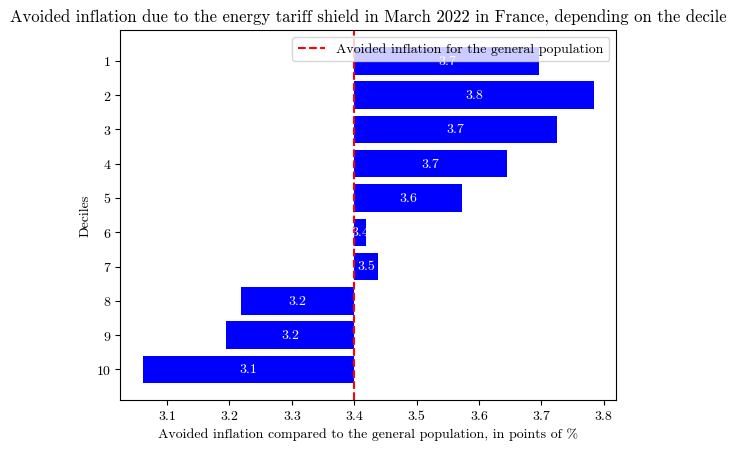

In [110]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter



# Creating the bar plot
fig, ax = plt.subplots()

bars = ax.barh(sumInflationAvoided.index, sumInflationAvoided['diffTot'], color='blue')

# Adding the line for the avoided inflation for the general population
ax.axvline(0, color='red', linestyle='--',
           label="Avoided inflation for the general population")

# Customizing x-axis labels by adding the value of the diff of inflation for the general population
def shifted_xaxis_formatter(x, pos):
    return f"{x + inflationAvoidedForTOT:.1f}"

formatter = FuncFormatter(shifted_xaxis_formatter)
ax.xaxis.set_major_formatter(formatter)

# Adding labels and legend
ax.set_xlabel("Avoided inflation compared to the general population, in points of %")
ax.set_ylabel("Deciles")
ax.set_title(
    "Avoided inflation due to the energy tariff shield in March 2022 in France, depending on the decile")
ax.legend()

# Adding values to the bars
for bar in bars:
    ax.text(bar.get_width()/2, bar.get_y() + bar.get_height()/2, f"{bar.get_width() + inflationAvoidedForTOT :.1f}", ha='center', va='center', color='white')


plt.rcParams['font.family'] = 'cmr10'
plt.savefig(f'saved_figs/figure26.png', dpi=500, bbox_inches='tight')
# Displaying the plot
plt.show()

In [111]:
sumInflationAvoided.to_csv("computed_data/106_inflation_avoided.csv")
